# Using Astropy Quantities and Units for astrophysical calculations

## Authors
Ana Bonaca, Erik Tollerud, Jonathan Foster, Lia Corrales, Kris Stern, Stephanie T. Douglas

## Learning Goals
* Use `Quantity` objects to estimate a hypothetical galaxy's mass
* Take advantage of constants in the `astropy.constants` library
* Print formatted unit strings
* Plot `Quantity` objects with unit labels, using `astropy.visualization.quantity_support`
* Do math with `Quantity` objects
* Convert quantities with `astropy.units`
* Convert between wavelength and energy with `astropy.units.spectral` equivalencies
* Use the small angle approximation with `astropy.units.dimensionless_angles` equivalencies
* Write functions that take `Quantity` objects instead of numpy arrays
* Make synthetic radio observations
* Use `Quantity` objects such as data cubes to facilitate a full derivation of the total mass of a molecular cloud

## Keywords
units, radio astronomy, data cubes, matplotlib

## Companion Content
[Tools for Radio Astronomy](https://www.springer.com/gp/book/9783662053942) by Rohlfs & Wilson

## Summary

In this tutorial we present some examples showing how Astropy's `Quantity` object can make astrophysics calculations easier. The examples include calculating the mass of a galaxy from its velocity dispersion and determining masses of molecular clouds from CO intensity maps. We end with an example of good practices for using quantities in functions you might distribute to other people.

For an in-depth discussion of `Quantity` objects, see the [astropy documentation section](http://docs.astropy.org/en/stable/units/quantity.html).

## Preliminaries

We start by loading standard libraries and set up plotting for ipython notebooks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# You shouldn't use the `seed` function in real science code, but we use it here for example purposes.
# It makes the "random" number generator always give the same numbers wherever you run it.
np.random.seed(12345)

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

It's conventional to load the Astropy `units` module as the variable  `u`, demonstrated below.  This will make working with `Quantity` objects much easier. 

Astropy also has a `constants` module where typical physical constants are available.  The constants are stored as objects of a subclass of `Quantity`, so they behave just like a `Quantity`. Here, we'll only need the gravitational constant `G`, Planck's constant `h`, and Boltzmann's constant, `k_B`.

In [2]:
import astropy.units as u
from astropy.constants import G, h, k_B

We will also show an example of plotting while taking advantage of the `astropy.visualization` package, which provides support for `Quantity` units.

In [3]:
from astropy.visualization import quantity_support

## 1. Galaxy mass

In this first example, we will use `Quantity` objects to estimate a hypothetical galaxy's mass, given its half-light radius and radial velocities of stars in the galaxy.

Let's assume that we measured the half-light radius of the galaxy to be 29 pc projected on the sky at the distance of the galaxy. This radius is often called the "effective radius", so we'll store it as a `Quantity` object with the name `Reff`. The easiest way to create a `Quantity` object is by multiplying the value with its unit. Units are accessed as u."unit", in this case u.pc.

In [4]:
Reff = 29 * u.pc

A completely equivalent (but more verbose) way of doing the same thing is to use the `Quantity` object's initializer, demonstrated below.  In general, the simpler form (above) is preferred, as it is closer to how such a quantity would actually be written in text.  The initalizer form has more options, though, which you can learn about from the [astropy reference documentation on Quantity](http://docs.astropy.org/en/stable/api/astropy.units.quantity.Quantity.html).

In [5]:
Reff = u.Quantity(29, unit=u.pc)

We can access the value and unit of a `Quantity` using the `value` and `unit` attributes.

In [6]:
print("""Half light radius
value: {0}
unit: {1}""".format(Reff.value, Reff.unit))

Half light radius
value: 29.0
unit: pc


The `value` and `unit` attributes can also be accessed within the print function.

In [7]:
print("""Half light radius
value: {0.value}
unit: {0.unit}""".format(Reff))

Half light radius
value: 29.0
unit: pc


Furthermore, we can convert the radius in parsecs to any other unit of length using the ``to()`` method. Here, we convert it to meters.

In [8]:
print("{0:.3g}".format(Reff.to(u.m)))

8.95e+17 m


Next, we'll first create a synthetic dataset of radial velocity measurements, assuming a normal distribution with a mean velocity of 206 km/s and a velocity dispersion of 4.3 km/s.

In [9]:
vmean = 206
sigin = 4.3
v = np.random.normal(vmean, sigin, 500)*u.km/u.s

In [10]:
print("""First 10 radial velocity measurements: 
{0}
{1}""".format(v[:10], v.to(u.m/u.s)[:10]))

First 10 radial velocity measurements: 
[205.11975706 208.05945635 203.76641353 203.61035969 214.45285646
 211.99164508 206.39950387 207.21150846 209.30679704 211.35966937] km / s
[205119.75706422 208059.45635365 203766.41352526 203610.35969131
 214452.85646176 211991.64508178 206399.50387    207211.50845717
 209306.79704073 211359.66936646] m / s


One can ocassionally run into issues when attempting to plot `Quantity` objects with `matplotlib` libraries. It is always possible to fix this by passing the value array (e.g., `v.value`) to `matplotlib` functions. However, calling the `astropy.visualization.quantity_support()` function will change the settings on your `matplotlib` session to better handle astropy `Quantity` objects:

In [11]:
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7f898bb45890>

Now we can plot a histogram of the velocity dataset. Note that, due to calling `quantity_support`, the x-axis is automatically labeled with the correct units.

Text(0, 0.5, 'N')

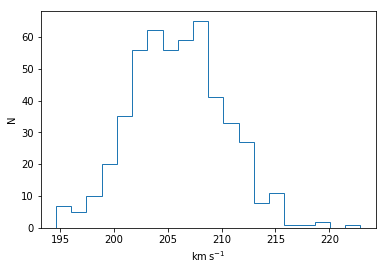

In [12]:
plt.figure()
plt.hist(v, bins='auto', histtype="step")
plt.ylabel("N")

Now we can calculate the velocity dispersion of the galaxy. This demonstrates how you can perform basic operations like subtraction and division with `Quantity` objects, and also use them in standard numpy functions such as `mean()` and `size()`. They retain their units through these operations just as you would expect them to.

In [13]:
sigma = np.sqrt(np.sum((v - np.mean(v))**2) / np.size(v))
print("Velocity dispersion: {0:.2f}".format(sigma))

Velocity dispersion: 4.36 km / s


Note how we needed to use `numpy` square root function, because the resulting velocity dispersion quantity is a `numpy` array. If we used the python standard `math` library's `sqrt` function instead, we get an error.

In [14]:
sigma_scalar = np.sqrt(np.sum((v - np.mean(v))**2) / len(v))

In general, you should only use `numpy` functions with `Quantity` objects, *not* the `math` equivalents, unless you are sure you understand the consequences.

Now for the actual mass calculation.  If a galaxy is pressure-supported (for example, an elliptical or dwarf spheroidal galaxy), its mass within the stellar extent can be estimated using a straightforward formula: $M_{1/2}=4\sigma^2 R_{eff}/G$.  There are caveats to the use of this formula for science -- see Wolf et al. 2010 for details.  For demonstrating `Quantity`, you can accept that this is often good enough. For the calculation, we can multiply the quantities together, and `astropy` will keep track of the units.

In [15]:
M = 4*sigma**2*Reff/G
M

<Quantity 3.30848411e+13 kg km2 pc / m3>

The result is in a composite unit, so it's not really obvious it's a mass. However, it can be decomposed to cancel all of the length units ($km^2 pc/m^3$) using the `decompose()` method.

In [16]:
M.decompose()

<Quantity 1.02089152e+36 kg>

We can also easily express the mass in whatever form you like -- solar masses are common in astronomy, or maybe you want the default SI and CGS units.

In [17]:
print("""Galaxy mass
in solar units: {0:.3g}
SI units: {1:.3g}
CGS units: {2:.3g}""".format(M.to(u.Msun), M.si, M.cgs))

Galaxy mass
in solar units: 5.13e+05 solMass
SI units: 1.02e+36 kg
CGS units: 1.02e+39 g


Or, if you want the log of the mass, you can just use ``np.log10`` as long as the logarithm's argument is dimensionless.

In [18]:
np.log10(M / u.Msun)

<Quantity 5.71047369>

However, you can't take the log of something with units, as that is not mathematically sensible.

In [19]:
np.log10(M)

UnitTypeError: Can only apply 'log10' function to dimensionless quantities

## Exercises

Use `Quantity` and Kepler's law in the form given below to determine the (circular) orbital speed of the Earth around the sun in km/s. No need to look up constants or conversion factors to do this calculation -- it's all in `astropy.units` and `astropy.constants`.

$$v = \sqrt{\frac{G M_{\odot}}{r}}$$

There's a much easier way to figure out the velocity of the Earth using just two units or quantities.  Do that and then compare to the Kepler's law answer (the easiest way is probably to compute the percentage difference, if any).

(Completely optional, but a good way to convince yourself of the value of Quantity:) Do the above calculations by hand -- you can use a calculator (or python just for its arithmatic) but look up all the appropriate conversion factors and use paper-and-pencil approaches for keeping track of them all.  Which one took longer?

## 2. Molecular cloud mass

In this second example, we will demonstrate how using `Quantity` objects can facilitate a full derivation of the total mass of a molecular cloud using radio observations of isotopes of Carbon Monoxide (CO).

#### Setting up the data cube

Let's assume that we've mapped the inner part of a molecular cloud in the J=1-0 rotational transition of ${\rm C}^{18}{\rm O}$  and are interested in measuring its total mass. The measurement produced a data cube with RA and Dec as spatial coordiates and velocity as the third axis. Each voxel in this data cube represents the brightness temperature of the emission at that position and velocity. Furthermore, we'll assume that we have an independent measurement of distance to the cloud $d=250$ pc and that the excitation temperature is known and constant throughout the cloud: $T_{ex}=25$ K.

In [20]:
d = 250 * u.pc
Tex = 25 * u.K

We'll generate a synthetic dataset, assuming the cloud follows a Gaussian distribution in each of RA, Dec and velocity. We start by creating a 100x100x300 numpy array, such that the first coordinate is right ascension, the second is declination, and the third is velocity.  We use the `numpy.meshgrid` function to create data cubes for each of the three coordinates, and then use them in the formula for a Gaussian to generate an array with the synthetic data cube. In this cube, the cloud is positioned at the center of the cube, with $\sigma$ and the center in each dimension shown below.  Note in particular that the $\sigma$ for RA and Dec have different units from the center, but `astropy` automatically does the relevant conversions before computing the exponential.

In [21]:
# Cloud's center
cen_ra = 52.25 * u.deg
cen_dec = 0.25 * u.deg
cen_v = 15 * u.km/u.s

# Cloud's size
sig_ra = 3 * u.arcmin
sig_dec = 4 * u.arcmin
sig_v = 3 * u.km/u.s

#1D coordinate quantities
ra = np.linspace(52, 52.5, 100) * u.deg
dec = np.linspace(0, 0.5, 100) * u.deg
v = np.linspace(0, 30, 300) *u.km/u.s

#this creates data cubes of size for each coordinate based on the dimensions of the other coordinates
ra_cube, dec_cube, v_cube = np.meshgrid(ra, dec, v)

data_gauss = np.exp(-0.5*((ra_cube-cen_ra)/sig_ra)**2 + 
                    -0.5*((dec_cube-cen_dec)/sig_dec)**2 + 
                    -0.5*((v_cube-cen_v)/sig_v)**2 )

The units of the exponential are dimensionless, so we multiply the data cube by K to get brightness temperature units. Radio astronomers use a rather odd set of units [K km/s] as of integrated intensity (that is, summing all the emission from a line over velocity). As an aside for experts, we're setting up our artificial cube on the main-beam temperature scale (T$_{\rm MB}$) which is the closest we can normally get to the actual brightness temperature of our source.

In [22]:
data = data_gauss * u.K

We will also need to know the width of each velocity bin and the size of each pixel, so let's calculate that now.

In [23]:
# Average pixel size
# This is only right if dec ~ 0, because of the cos(dec) factor.
dra = (ra.max() - ra.min()) / len(ra)
ddec = (dec.max() - dec.min()) / len(dec)

#Average velocity bin width
dv = (v.max() - v.min()) / len(v)
print("""dra = {0}
ddec = {1}
dv = {2}""".format(dra.to(u.arcsec), ddec.to(u.arcsec), dv))

dra = 18.0 arcsec
ddec = 18.0 arcsec
dv = 0.1 km / s


We're interested in the integrated intensity over all of the velocity channels, so let's create a 2D quantity array by summing our data cube along the velocity axis (multiplying by the velocity width of a pixel).

In [24]:
intcloud = np.sum(data*dv, axis=2)
intcloud.unit

Unit("K km / s")

We can plot the 2D quantity using matplotlib's imshow function, by passing the quantity's value. Similarly, we can set the correct extent using the values of $x_i$ and $x_f$. Finally, we can set the colorbar label to have proper units.

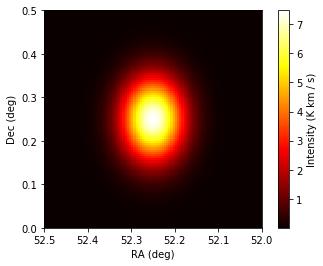

In [25]:
#Note that we display RA in the convential way by going from max to min
plt.imshow(intcloud.value, 
           origin='lower', 
           extent=[ra.value.max(), ra.value.min(), dec.value.min(), dec.value.max()], 
           cmap='hot', 
           interpolation='nearest', 
           aspect='equal')
plt.colorbar().set_label("Intensity ({})".format(intcloud.unit))
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)");

#### Measuring The Column Density of CO

In order to calculate the mass of the molecular cloud, we need to measure its column density. A number of assumptions are required for the following calculation; the most important are that the emission is optically thin (typically true for ${\rm C}^{18}{\rm O}$) and that conditions of local thermodynamic equilibrium hold along the line of sight. In the case where the temperature is large compared to the separation in energy levels for a molecule and the source fills the main beam of the telescope, the total column density for ${\rm C}^{13}{\rm O}$ is

$N=C \frac{\int T_B(V) dV}{1-e^{-B}}$

where the constants $C$ and $B$ are given by:

$C=3.0\times10^{14} \left(\frac{\nu}{\nu_{13}}\right)^2 \frac{A_{13}}{A} {\rm K^{-1} cm^{-2} \, km^{-1} \, s}$

$B=\frac{h\nu}{k_B T}$

(Rohlfs & Wilson [Tools for Radio Astronomy](https://www.springer.com/gp/book/9783662053942)). 

Here we have given an expression for $C$ scaled to the values for ${\rm C}^{13}{\rm O}$ ($\nu_{13}$ and $A_{13}$). In order to use this relation for ${\rm C}^{18}{\rm O}$, we need to rescale the frequencies ${\nu}$ and Einstein coefficients $A$. $C$ is in funny mixed units, but that's okay. We'll define it as a `Quantities` object and not have to worry about it. 

First, we look up the wavelength for these emission lines and store them as quantities. 

In [26]:
lambda13 = 2.60076 * u.mm
lambda18 = 2.73079 * u.mm

Since the wavelength and frequency of light are related using the speed of light, we can convert between them. However, doing so just using the `to()` method fails, as units of length and frequency are not convertible:

In [27]:
nu13 = lambda13.to(u.Hz)
nu18 = lambda18.to(u.Hz)

UnitConversionError: 'mm' (length) and 'Hz' (frequency) are not convertible

Fortunately, `astropy` comes to the rescue by providing a feature called "unit equivalencies."  Equivalencies provide a way to convert between two physically different units that are not normally equivalent, but in a certain context have a one-to-one mapping.  For more on equivalencies, see the [equivalencies section of astropy's documentation](http://docs.astropy.org/en/stable/units/equivalencies.html).

In this case, calling the ``astropy.units.spectral()`` function provides the equivalencies necessary to handle conversions between wavelength and frequency. To use it, provide the equivalencies to the `equivalencies` keyword of the ``to()`` call:

In [28]:
nu13 = lambda13.to(u.Hz, equivalencies=u.spectral())
nu18 = lambda18.to(u.Hz, equivalencies=u.spectral())

Next, we look up Einstein coefficients (in units of s$^{-1}$), and calculate the ratios in constant $C$. Note how the ratios of frequency and Einstein coefficient units are dimensionless, so the unit of $C$ is unchanged.

In [29]:
nu13 = 115271096910.13396 * u.Hz
nu18 = 109782318669.689 * u.Hz
A13 = 7.4e-8 / u.s
A18 = 8.8e-8 / u.s

C = 3e14 * (nu18/nu13)**3 * (A13/A18) / (u.K * u.cm**2 * u.km *(1/u.s))
C

<Quantity 2.17924582e+14 s / (cm2 K km)>

Now we move on to calculate the constant $B$. This is given by the ratio of $\frac{h\nu}{k_B T}$, where $h$ is Planck's constant, $k_B$ is the Boltzmann's constant, $\nu$ is the emission frequency, and $T$ is the excitation temperature. The constants were imported from `astropy.constants`, and the other two values are already calculated, so here we just take the ratio.

In [30]:
B = h * nu18 / (k_B * Tex)

The units of $B$ are Hz sec, which can be decomposed to a dimensionless unit if you actually care about its value.  Usually this is not necessary, though. Quantities are at their best if you use them without worrying about intermediate units, and only convert at the very end when you want a final answer.

In [31]:
print('{0}\n{1}'.format(B, B.decompose()))

0.21074881298143522 Hz s
0.21074881298143522


At this point we have all the ingredients to calculate the number density of $\rm CO$ molecules in this cloud. We already integrated (summed) over the velocity channels above to show the integrated intensity map, but we'll do it again here for clarity. This gives us the column density of CO for each spatial pixel in our map. We can then print out the peak column column density.

In [32]:
NCO = C * np.sum(data*dv, axis=2) / (1 - np.exp(-B))
print("Peak CO column density: ")
np.max(NCO)

Peak CO column density: 


<Quantity 8.5782091e+15 1 / cm2>

#### CO to Total Mass

We are using CO as a tracer for the much more numerous H$_2$, the quantity we are actually trying to infer. Since most of the mass is in H$_2$, we calculate its column density by multiplying the CO column density with the (known/assumed) H$_2$/CO ratio.

In [33]:
H2_CO_ratio = 5.9e6
NH2 = NCO * H2_CO_ratio
print("Peak H2 column density: ")
np.max(NH2)

Peak H2 column density: 


<Quantity 5.06114337e+22 1 / cm2>

That's a peak column density of roughly 50 magnitudes of visual extinction (assuming the conversion between N$_{\rm H_2}$ and A$_V$ from Bohlin et al. 1978), which seems reasonable for a molecular cloud.

We obtain the mass column density by multiplying the number column density by the mass of an individual H$_2$ molecule. 

In [34]:
mH2 = 2 * 1.008 * u.Dalton  #aka atomic mass unit/amu
rho = NH2 * mH2

A final step in going from the column density to mass is summing up over the area area. If we do this in the straightforward way of length x width of a pixel, this area is then in units of ${\rm deg}^2$.

In [35]:
dap = dra * ddec
print(dap)

2.5e-05 deg2


Now comes an important subtlety: in the small angle approximation, multiplying the pixel area with the square of distance yields the cross-sectional area of the cloud that the pixel covers, in *physical* units, rather than angular units.  So it's tempting to just multiply the area and the square of the distance.

In [36]:
da = dap * d**2  # don't actually do it this way - use the version below instead!
print(da)

1.5625 deg2 pc2


In [37]:
dap.to(u.steradian).value * d**2

<Quantity 0.00047596 pc2>

But this is **wrong**, because `astropy.units` treats angles (and solid angles) as actual physical units, while the small-angle approximation assumes angles are dimensionless.  So if you, e.g., try to convert to a different area unit, it will fail:

In [38]:
da.to(u.cm**2)

UnitConversionError: 'deg2 pc2' and 'cm2' (area) are not convertible

The solution is to use the `dimensionless_angles` equivalency, which allows angles to be treated as dimensionless.  This makes it so that they will automatically convert to radians and become dimensionless when a conversion is needed.

In [39]:
da = (dap * d**2).to(u.pc**2, equivalencies=u.dimensionless_angles())
da

<Quantity 0.00047596 pc2>

In [40]:
da.to(u.cm**2)

<Quantity 4.53185339e+33 cm2>

Finally, multiplying the column density with the pixel area and summing over all the pixels gives us the cloud mass.

In [41]:
M = np.sum(rho * da)
M.decompose().to(u.solMass)

<Quantity 317.6484309 solMass>

## Exercises

The astro material was pretty heavy on that one, so let's focus on some associated statistics using `Quantity`'s array capabililities. Compute the median and mean of the `data` with the ``np.mean`` and ``np.median`` functions.  Why are their values so different?

Similarly, compute the standard deviation and variance (if you don't know the relevant functions, look it up in the numpy docs or just type np.<tab> and a code cell).  Do they have the units you expect?

## 3. Using Quantities with Functions

`Quantity` is also a useful tool if you plan to share some of your code, either with collaborators or the wider community.  By writing functions that take `Quantity` objects instead of raw numbers or arrays, you can write code that is agnostic to the input unit.  In this way, you may even be able to prevent [the destruction of Mars orbiters](http://en.wikipedia.org/wiki/Mars_Climate_Orbiter#Cause_of_failure). Below, we provide a simple example.

Suppose you are working on an instrument, and the person funding it asks for a function to give an analytic estimate of the response function.  You determine from some tests it's basically a Lorentzian, but with a different scale along the two axes.  Your first thought might be to do this:

In [42]:
def response_func(xinarcsec, yinarcsec):
    xscale = 0.9
    yscale = 0.85
    xfactor = 1 / (1 + xinarcsec/xscale)
    yfactor = 1 / (1 + yinarcsec/yscale)
    
    return xfactor * yfactor

You meant the inputs to be in arcsec, but alas, you send that to your collaborator and they don't look closely and think the inputs are instead supposed to be in arcmin.  So they do:

In [43]:
response_func(1.0, 1.2)

0.19640564826700893

And now they tell all their friends how terrible the instrument is, because it's supposed to have arcsecond resolution, but your function clearly shows it can only resolve an arcmin at best. But you can solve this by requiring they pass in `Quantity` objects.  The new function could simply be:

In [44]:
def response_func(x, y):
    xscale = 0.9 * u.arcsec
    yscale = 0.85 * u.arcsec
    xfactor = 1 / (1 + x/xscale)
    yfactor = 1 / (1 + y/yscale)
    
    return xfactor * yfactor

And your collaborator now has to pay attention.  If they just blindly put in a number they get an error:

In [45]:
response_func(1.0, 1.2)

UnitConversionError: Can only apply 'add' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan)

Which is their cue to provide the units explicitly:

In [46]:
response_func(1.0*u.arcmin, 1.2*u.arcmin)

<Quantity 0.00017243>

The funding agency is impressed at the resolution you achieved, and your instrument is saved!  You now go on to win the Nobel Prize due to discoveries the instrument makes.  And it was all because you used `Quantity` as the input of code you shared.

## Exercise

Write a function that computes the Keplerian velocity you worked out in section 1 (using `Quantity` input and outputs, of course), but allowing for an arbitrary mass and orbital radius.  Try it with some reasonable numbers for satellites orbiting the Earth, a moon of Jupiter, or an extrasolar planet.  Feel free to use wikipedia or similar for the masses and distances.  